# COMP90051 Project 2

In [30]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [31]:
"""
todo
1. Exception处理
2. 英文翻译
"""
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [237]:
def index_max(input_list):
    """
    return the index of the max element in the list.
    NOTICE: Tie-breaking uniformly among value-maximising arms.
    arm 0 是第一个arm
    """
    m = max(input_list)
    if m == np.inf:
        index_list = [i for i, j in enumerate(input_list) if j==np.inf]
    else:
        # handle with float
        index_list = [i for i, j in enumerate(input_list) if (abs(j-m)<=0.000001)]
        
    if len(index_list) == 1:
        return index_list[0]
    else:
        return np.random.choice(index_list)

In [51]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms=narms
        self.epsilon=epsilon
        # 记录每一个arm的pull的次数和得到的reward
        self.counts = [0 for col in range(self.narms)]
        self.avg_rewards = [Q0 for col in range(self.narms)]
        
    def play(self, tround, context=None):
        """
        Play a round
        play t-1轮的
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        # exploit
        if np.random.random() > self.epsilon:
            # t-1轮中的average reward中最大的
            return index_max(self.avg_rewards)
        else:
        # explore
            return np.random.randint(self.narms)
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        更新t轮的
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        old_avg_reward = self.avg_rewards[arm]
        new_avg_reward = (old_avg_reward * (n-1) + reward)/n
        self.avg_rewards[arm] = new_avg_reward

In [ ]:
# todo
# 它的下一个是顺序下来找的，还是所有里面的随机找。


In [82]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        # 记录每一个arm的次数和reward
        self.counts = [0 for col in range(self.narms)]
        self.avg_rewards = [Q0 for col in range(self.narms)]
        
    def play(self, tround, context=None):
        """
        Play a round
        t-1 round
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        # tround is used for UCB
        q_values = [0.0 for arm in range(self.narms)]
        for arm in range(self.narms):
            # todo 这里其他人怎么处理
            if self.counts[arm] == 0:
                bonus = 0
            else:
                # 看下evaluation的tround是不是第t轮而不是t-1轮的结果
                bonus = np.sqrt((self.rho*np.log(tround))/self.counts[arm])
            # 是使得当前tround下达到最大的，和update不一样，update是选完arm后的action.
            q_values[arm] = self.avg_rewards[arm] + bonus
        return index_max(q_values)
        
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        需要update avg_rewards和self.counts
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        old_avg_reward = self.avg_rewards[arm]
        new_avg_reward = (old_avg_reward * (n-1) + reward)/n
        self.avg_rewards[arm] = new_avg_reward

## 2. Off-Policy Evaluation

In [239]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    rewards_for_matched_round = []
    tround = 1
    length = len(rewards)
    for context_round in range(length):
        # tround是从0开始的
        # end  
        # pull/play 一次
        context = contexts[context_round]
        response_arm = int(arms[context_round]-1)
        response_reward = rewards[context_round]
        estimate_arm = int(mab.play(tround, context))
        if estimate_arm == response_arm:
            tround += 1
            rewards_for_matched_round.append(response_reward)
            # update
            mab.update(response_arm, response_reward, context)
        if tround > nrounds:
            break
    return rewards_for_matched_round

In [194]:
# load the data
dataset = np.loadtxt('dataset.txt', dtype=int)
arms = dataset[:,0]
rewards = dataset[:,1]
contexts = dataset[:,2:102]

In [296]:
import pandas as pd
df = pd.DataFrame(dataset)
df.groupby(1).count()

,0,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,101
1,,,,,,,,,,,,,,,,,,,,,
0,8961,8961,8961,8961,8961,8961,8961,8961,8961,8961,...,8961,8961,8961,8961,8961,8961,8961,8961,8961,8961
1,1039,1039,1039,1039,1039,1039,1039,1039,1039,1039,...,1039,1039,1039,1039,1039,1039,1039,1039,1039,1039


In [249]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.18625


In [250]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.1725


## 3. Contextual Bandits

In [155]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.A_list = [np.identity(ndims) for col in range(self.narms)]
        self.b_list = [np.zeros((ndims, 1)) for col in range(self.narms)]

    def play(self, tround, context=None):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
        p_ta_list = [0.0 for col in range(self.narms)]
        for arm in range(self.narms):
            context_arm = context[arm*10:(arm+1)*10]
            # todo
            x_ta = np.array(context_arm).reshape(-1,1)
            theta_a = np.dot(inv(self.A_list[arm]), self.b_list[arm])
            p_ta = np.dot(theta_a.T, x_ta) + self.alpha*np.sqrt(np.linalg.multi_dot([x_ta.T, inv(self.A_list[arm]), x_ta]))
            p_ta_list[arm] = p_ta[0]
        return index_max(p_ta_list)
        
    def update(self, arm, reward, context=None):
        """
        Updates the internal state of the MAB after a play
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """
        old_A_value = np.array((self.A_list[arm]))
        old_b_value = np.array((self.b_list[arm]))
        context_arm = context[arm*10:(arm+1)*10]
        x_tat = np.array(context_arm).reshape(-1,1)    
        self.A_list[arm] = old_A_value + np.dot(x_tat, x_tat.T)
        self.b_list[arm] = old_b_value + reward * x_tat
    

In [108]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))
# linUCB不是固定的么

LinUCB average reward 0.29125


## 4. Evaluation
### 4.A.

In [70]:
number_of_trials = np.linspace(1, 800, 800)

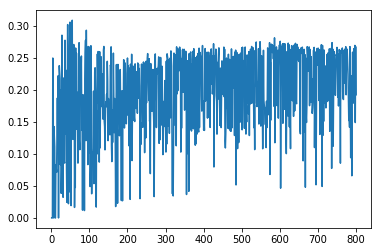

In [243]:
result_mab_eps = []
for number_of_trial in number_of_trials:
    mab_eps = EpsGreedy(10, 0.05)
    result_rewards_per_trial = offlineEvaluate(mab_eps, arms, rewards, contexts, int(number_of_trial))
    result_mab_eps.append(np.mean(result_rewards_per_trial))
fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, 800, 800)
ax.plot(x, result_mab_eps);

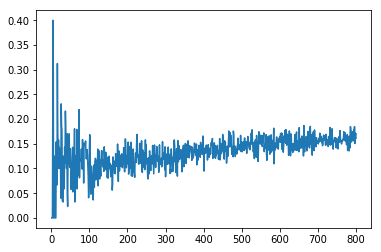

In [241]:
result_mab_ucb = []
for number_of_trial in number_of_trials:
    mab_ucb = UCB(10, 1.0)
    result_rewards_per_trial = offlineEvaluate(mab_ucb, arms, rewards, contexts, int(number_of_trial))
    result_mab_ucb.append(np.mean(result_rewards_per_trial))

fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, 800, 800)
ax.plot(x, result_mab_ucb);

In [245]:
result_mab_linucb = []
for number_of_trial in tqdm(number_of_trials):
    mab_linucb = LinUCB(10, 10, 1.0)
    result_rewards_per_trial = offlineEvaluate(mab_linucb, arms, rewards, contexts, int(number_of_trial))
    result_mab_linucb.append(np.mean(result_rewards_per_trial))



  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 3/800 [00:00<00:49, 15.94it/s]

  0%|          | 4/800 [00:00<00:59, 13.27it/s]

  1%|          | 6/800 [00:00<01:00, 13.05it/s]

  1%|          | 7/800 [00:00<01:13, 10.82it/s]

  1%|          | 8/800 [00:00<01:26,  9.18it/s]

  1%|          | 9/800 [00:00<01:24,  9.33it/s]

  1%|▏         | 10/800 [00:00<01:27,  9.07it/s]

  1%|▏         | 11/800 [00:01<01:35,  8.29it/s]

  2%|▏         | 12/800 [00:01<01:45,  7.49it/s]

  2%|▏         | 13/800 [00:01<01:46,  7.39it/s]

  2%|▏         | 14/800 [00:01<01:47,  7.30it/s]

  2%|▏         | 15/800 [00:01<01:55,  6.78it/s]

  2%|▏         | 16/800 [00:01<02:08,  6.11it/s]

  2%|▏         | 17/800 [00:02<02:12,  5.92it/s]

  2%|▏         | 18/800 [00:02<02:14,  5.80it/s]

  2%|▏         | 19/800 [00:02<02:41,  4.83it/s]

  2%|▎         | 20/800 [00:02<02:40,  4.87it/s]

  3%|▎         | 21/800 [00:02<02:35,  5.01it/s]

  3%|▎         | 22/800 [00:03<02:39,  4.88it/s]

  3%|▎       

 18%|█▊        | 148/800 [01:17<09:17,  1.17it/s]

 19%|█▊        | 149/800 [01:18<09:09,  1.18it/s]

 19%|█▉        | 150/800 [01:19<09:56,  1.09it/s]

 19%|█▉        | 151/800 [01:20<10:15,  1.05it/s]

 19%|█▉        | 152/800 [01:21<11:06,  1.03s/it]

 19%|█▉        | 153/800 [01:22<11:09,  1.04s/it]

 19%|█▉        | 154/800 [01:23<10:45,  1.00it/s]

 19%|█▉        | 155/800 [01:24<10:28,  1.03it/s]

 20%|█▉        | 156/800 [01:25<10:08,  1.06it/s]

 20%|█▉        | 157/800 [01:26<10:40,  1.00it/s]

 20%|█▉        | 158/800 [01:27<10:55,  1.02s/it]

 20%|█▉        | 159/800 [01:28<11:08,  1.04s/it]

 20%|██        | 160/800 [01:29<11:12,  1.05s/it]

 20%|██        | 161/800 [01:30<10:39,  1.00s/it]

 20%|██        | 162/800 [01:31<10:23,  1.02it/s]

 20%|██        | 163/800 [01:32<10:50,  1.02s/it]

 20%|██        | 164/800 [01:33<10:44,  1.01s/it]

 21%|██        | 165/800 [01:34<11:12,  1.06s/it]

 21%|██        | 166/800 [01:35<10:53,  1.03s/it]

 21%|██        | 167/800 [01:36

 36%|███▋      | 291/800 [04:23<14:13,  1.68s/it]

 36%|███▋      | 292/800 [04:25<13:56,  1.65s/it]

 37%|███▋      | 293/800 [04:27<13:26,  1.59s/it]

 37%|███▋      | 294/800 [04:28<13:39,  1.62s/it]

 37%|███▋      | 295/800 [04:30<13:48,  1.64s/it]

 37%|███▋      | 296/800 [04:32<13:54,  1.66s/it]

 37%|███▋      | 297/800 [04:33<13:22,  1.60s/it]

 37%|███▋      | 298/800 [04:35<13:58,  1.67s/it]

 37%|███▋      | 299/800 [04:37<14:05,  1.69s/it]

 38%|███▊      | 300/800 [04:38<13:44,  1.65s/it]

 38%|███▊      | 301/800 [04:40<13:20,  1.60s/it]

 38%|███▊      | 302/800 [04:41<13:20,  1.61s/it]

 38%|███▊      | 303/800 [04:43<13:43,  1.66s/it]

 38%|███▊      | 304/800 [04:45<13:43,  1.66s/it]

 38%|███▊      | 305/800 [04:46<13:44,  1.67s/it]

 38%|███▊      | 306/800 [04:48<13:14,  1.61s/it]

 38%|███▊      | 307/800 [04:49<13:10,  1.60s/it]

 38%|███▊      | 308/800 [04:51<13:02,  1.59s/it]

 39%|███▊      | 309/800 [04:53<12:47,  1.56s/it]

 39%|███▉      | 310/800 [04:54

 54%|█████▍    | 434/800 [09:21<14:19,  2.35s/it]

 54%|█████▍    | 435/800 [09:23<14:18,  2.35s/it]

 55%|█████▍    | 436/800 [09:26<14:01,  2.31s/it]

 55%|█████▍    | 437/800 [09:28<14:13,  2.35s/it]

 55%|█████▍    | 438/800 [09:30<14:06,  2.34s/it]

 55%|█████▍    | 439/800 [09:33<14:08,  2.35s/it]

 55%|█████▌    | 440/800 [09:35<13:57,  2.33s/it]

 55%|█████▌    | 441/800 [09:37<14:07,  2.36s/it]

 55%|█████▌    | 442/800 [09:40<13:56,  2.34s/it]

 55%|█████▌    | 443/800 [09:42<13:56,  2.34s/it]

 56%|█████▌    | 444/800 [09:45<14:07,  2.38s/it]

 56%|█████▌    | 445/800 [09:47<14:34,  2.46s/it]

 56%|█████▌    | 446/800 [09:50<14:24,  2.44s/it]

 56%|█████▌    | 447/800 [09:52<14:06,  2.40s/it]

 56%|█████▌    | 448/800 [09:55<14:33,  2.48s/it]

 56%|█████▌    | 449/800 [09:57<14:48,  2.53s/it]

 56%|█████▋    | 450/800 [10:00<14:59,  2.57s/it]

 56%|█████▋    | 451/800 [10:03<15:06,  2.60s/it]

 56%|█████▋    | 452/800 [10:05<15:12,  2.62s/it]

 57%|█████▋    | 453/800 [10:08

 72%|███████▏  | 577/800 [17:24<11:06,  2.99s/it]

 72%|███████▏  | 578/800 [17:27<10:56,  2.96s/it]

 72%|███████▏  | 579/800 [17:30<11:11,  3.04s/it]

 72%|███████▎  | 580/800 [17:33<11:14,  3.07s/it]

 73%|███████▎  | 581/800 [17:37<12:27,  3.41s/it]

 73%|███████▎  | 582/800 [17:41<12:20,  3.40s/it]

 73%|███████▎  | 583/800 [17:44<12:02,  3.33s/it]

 73%|███████▎  | 584/800 [17:47<11:54,  3.31s/it]

 73%|███████▎  | 585/800 [17:50<11:55,  3.33s/it]

 73%|███████▎  | 586/800 [17:54<11:33,  3.24s/it]

 73%|███████▎  | 587/800 [17:56<11:12,  3.16s/it]

 74%|███████▎  | 588/800 [18:01<12:30,  3.54s/it]

 74%|███████▎  | 589/800 [18:05<13:25,  3.82s/it]

 74%|███████▍  | 590/800 [18:09<12:55,  3.69s/it]

 74%|███████▍  | 591/800 [18:12<12:32,  3.60s/it]

 74%|███████▍  | 592/800 [18:15<12:09,  3.51s/it]

 74%|███████▍  | 593/800 [18:19<12:07,  3.52s/it]

 74%|███████▍  | 594/800 [18:22<11:52,  3.46s/it]

 74%|███████▍  | 595/800 [18:26<11:42,  3.43s/it]

 74%|███████▍  | 596/800 [18:29

 90%|█████████ | 720/800 [26:45<06:18,  4.73s/it]

 90%|█████████ | 721/800 [26:50<06:17,  4.78s/it]

 90%|█████████ | 722/800 [26:54<06:03,  4.66s/it]

 90%|█████████ | 723/800 [26:58<05:45,  4.49s/it]

 90%|█████████ | 724/800 [27:03<05:41,  4.49s/it]

 91%|█████████ | 725/800 [27:08<05:39,  4.52s/it]

 91%|█████████ | 726/800 [27:12<05:39,  4.58s/it]

 91%|█████████ | 727/800 [27:16<05:16,  4.34s/it]

 91%|█████████ | 728/800 [27:20<04:59,  4.15s/it]

 91%|█████████ | 729/800 [27:24<04:51,  4.11s/it]

 91%|█████████▏| 730/800 [27:28<04:40,  4.01s/it]

 91%|█████████▏| 731/800 [27:32<04:42,  4.09s/it]

 92%|█████████▏| 732/800 [27:37<05:00,  4.42s/it]

 92%|█████████▏| 733/800 [27:42<05:13,  4.67s/it]

 92%|█████████▏| 734/800 [27:47<05:17,  4.81s/it]

 92%|█████████▏| 735/800 [27:53<05:22,  4.96s/it]

 92%|█████████▏| 736/800 [27:57<04:56,  4.64s/it]

 92%|█████████▏| 737/800 [28:01<04:47,  4.57s/it]

 92%|█████████▏| 738/800 [28:05<04:41,  4.54s/it]

 92%|█████████▏| 739/800 [28:11

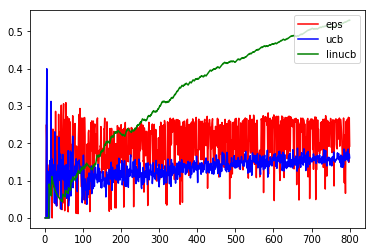

In [246]:
# Answer
fig = plt.figure()
ax = plt.axes()
x = np.linspace(1, 800, 800)
ax.plot(x, result_mab_eps, 'r', label='eps')
ax.plot(x, result_mab_ucb, 'b', label='ucb')
ax.plot(x, result_mab_linucb, 'g', label='linucb')
ax.legend(loc='upper right')

### 4.B.

1.5887050112577374
2.949474603520405


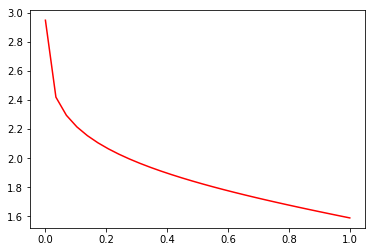

In [152]:
# 0.1, 0.01
# alpha越大，去探索的概率越大。但是说明delta越小，1-delta越大，说明置信度越高。
# alpha最小，alpha最大3
fig = plt.figure()
ax = plt.axes()
delta = np.linspace(0.001, 1, 30)
ax.plot(delta,list(map(lambda delta:(1  + np.sqrt(np.log(2/delta)/2)), delta)), 'r')
print(min(list(map(lambda delta:(1  + np.sqrt(np.log(2/delta)/2)), delta))))
print(max(list(map(lambda delta:(1  + np.sqrt(np.log(2/delta)/2)), delta))))
# A reasonable range of alpha will be 1.6 to 3

In [ ]:
np.linspace(0, 1, 10)

best alpha:2.3777777777777778


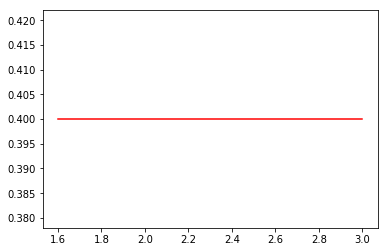

In [158]:
def grid_search(alpha_start, alpha_end):
    result_linucb_alpha = []
    for alpha in np.linspace(alpha_start, alpha_end, 10):
        result_rewards_per_alpha=[]
        mab_linucb = LinUCB(10, 10, alpha)
        result_rewards_per_alpha = offlineEvaluate(mab_linucb, arms, rewards, contexts, 100)
        result_linucb_alpha.append(np.mean(result_rewards_per_alpha))
    best_alpha = np.linspace(alpha_start, alpha_end, 10)[index_max(result_linucb_alpha)]
    return result_linucb_alpha, best_alpha

alpha_start = 1.6
alpha_end = 3
result_linucb_alpha, best_alpha = grid_search(alpha_start, alpha_end)
fig = plt.figure()
ax = plt.axes()
x = np.linspace(alpha_start, alpha_end, 10)
print('best alpha:' + str(best_alpha))
ax.plot(x,result_linucb_alpha, 'r')
# todo 我的alpha的变化不会导致结果的变化

## 5. KernelUCB

In [131]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [172]:
l = np.array([1,2,5,3])
np.array([1] + [0]*(10-1)).reshape(-1,1)

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [190]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        self.narms = narms
        self.ndims = ndims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.u = np.array([1] + [0]*(self.narms-1)).reshape(-1,1)
        self.y = list()
        self.xt_history = list()
        self.K_t_minus1_inverse = None
        self.tround=None
    
    def play(self, tround, context):
        # 返回argmax(u_t-1)
        self.tround = tround
        return index_max(self.u)
    
    def update(self, arm, reward, context):
        # 继续做u_t的东西
        x_t = context[arm*10:(arm+1)*10]
        # length为t-1
        self.y.append(reward)
        # length为t了
        self.xt_history.append(x_t)
        y_t = np.array(self.y).reshape(-1,1)
        # t * 1 dimensional
        # 需要x_t, xt_history, tround
        # 注意xt_history得是tround * 1 的
        print([x_t]*self.tround)
        print(self.xt_history)
        k_xt_t = np.array(list(map(lambda x,y:kern(x,y),[x_t]*self.tround, self.xt_history))).reshape(-1,1)
        
        if self.tround == 1:
            K_t_inverse = 1/(self.kern(x_t, x_t) + self.eta)
            self.K_t_minus1_inverse = K_t_inverse
        else:
            # (tround - 1) * 1的
            b = np.array(list(map(lambda x,y:kern(x,y),[x_t]*self.tround, self.xt_history[:-1]))).reshape(-1,1)
            K_22 = 1/(self.kern(x_t, x_t) + self.eta - np.linalg.multi_dot([b.T, self.K_t_minus1_inverse, b]))
            K_11 = self.K_t_minus1_inverse + np.linalg.multi_dot([K_22, self.K_t_minus1_inverse, b, b.T, self.K_t_minus1_inverse])
            K_12 = np.linalg.multi_dot([-K_22, self.K_t_minus1_inverse, b])
            K_21 = np.linalg.multi_dot([-K_22, b.T, self.K_t_minus1_inverse])
            K_t_inverse = np.block([[K_11, K_12],[K_21, K_22]])
        sigma_t = []
        u_t = []
        for arm in range(self.narms):
            x_nt = context[arm*10:(arm+1)*10].reshape(1,-1)
            sigma_nt = np.sqrt(self.kern(x_nt, x_nt) - np.linalg.multi_dot([k_xt_t.T, K_t_inverse, k_xt_t]))
            sigma_t.append(sigma_nt)
            u_nt = np.linalg.multi_dot([k_xt_t.T, K_t_inverse, y_t]) + self.eta/sqrt(self.gamma) * sigma_nt
            u_t.append(u_nt)
        # 更新u_t
        self.u = u_t
        # 下一轮的
        self.K_t_minus1_inverse = K_t_inverse

In [191]:
def kern(X, Y):
    """
    RBF_kernel with gamma preset
    """
    gamma = 0.1
    X = X.reshape(-1,1)
    Y = Y.reshape(-1,1)
    return rbf_kernel(X, Y, gamma)

mab_kern = KernelUCB(10, 10, 0.05, 0.1, kern)
results_kern = offlineEvaluate(mab_kern, arms, rewards, contexts, 800)
print(results_kern)
print('kernel average reward', np.mean(results_kern))

[array([22,  0,  0, 38,  0,  0,  0,  0,  0,  0])]
[array([22,  0,  0, 38,  0,  0,  0,  0,  0,  0])]


ValueError: shapes (10,10) and (100,1) not aligned: 10 (dim 1) != 100 (dim 0)